In [ ]:
# Clone the repo from your branch
!rm -rf nlp-project
!git clone -b 5-variational-siamese-encoder https://github.com/MahitGtg/nlp-project.git

# Move into the repo
%cd nlp-project

# Check which branch you are on
!git branch
!git status



Cloning into 'nlp-project'...
fatal: could not read Username for 'https://github.com': No such device or address
[Errno 2] No such file or directory: 'nlp-project'
/content
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


# 2025 CITS4012 Project 2

## 1. Preprocessing

### 1.1. Import Libraries
Libraries are imported for the entire project.

*Note: Just add to this list as needed*

In [1]:
%pip install gensim
import gensim.downloader as api

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import time
import torch
import spacy
import re

torch.manual_seed(42)
random.seed(42)

### 1.2. Retrieve Data
First, we need to retrieve the train/val/test datafiles from the Google Drive.

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
train_fileid = "1YEOo5vd8DXXUCf1FXCR1D3PxWR9XxQKv"
val_fileid = "15FEgtzzTVDMQcNVMgwIwqoAJeF9vmtrX"
test_fileid = "179nwaOvdkZ3ogsBaTSJvpZEIjq20uiG-"

train_file = drive.CreateFile({'id': train_fileid})
val_file = drive.CreateFile({'id': val_fileid})
test_file = drive.CreateFile({'id': test_fileid})

train_file.GetContentFile('train.json')
val_file.GetContentFile('val.json')
test_file.GetContentFile('test.json')

### 1.3. Read in the Data
We now read in each dataset, splitting the input data and target data. The data shapes and a sample of the training data are shown below.

In [4]:
train = pd.read_json('train.json')
X_train = train[['premise', 'hypothesis']]
y_train = train['label']

val = pd.read_json('val.json')
X_val = val[['premise', 'hypothesis']]
y_val = val['label']

test = pd.read_json('test.json')
X_test = test[['premise', 'hypothesis']]
y_test = test['label']

print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
display(train)

Train shape: (23088, 2)
Val shape: (1304, 2)
Test shape: (2126, 2)


,premise,hypothesis,label
0,Pluto rotates once on its axis every 6.39 Eart...,Earth rotates on its axis once times in one day.,neutral
1,---Glenn =====================================...,Earth rotates on its axis once times in one day.,entails
2,geysers - periodic gush of hot water at the su...,The surface of the sun is much hotter than alm...,neutral
3,Facts: Liquid water droplets can be changed in...,Evaporation is responsible for changing liquid...,entails
4,"By comparison, the earth rotates on its axis o...",Earth rotates on its axis once times in one day.,entails
...,...,...,...
23083,"which is not only the motion of our bodies, bu...",Work is done only if a force is exerted in the...,neutral
23084,"The Red Star, that celestial curse whose eccen...",Red-shift refers to a shift toward red in the ...,neutral
23085,The lines in the spectrum of a luminous body s...,Red-shift refers to a shift toward red in the ...,entails
23086,The radial velocity of a star away from or tow...,Red-shift refers to a shift toward red in the ...,entails


#### 1.3.1 Label Mapping and Dicts
Convert each row to a dict and apply a fixed label map (entails: 1, neutral: 0) so downstream code gets consistent integer labels.

In [7]:

LABEL_MAP = {"entails": 1, "neutral": 0}

def df_to_examples(df):
    # Keep premise/hypothesis separate; attach deterministic int label y
    return [
        {
            "premise": row.premise,
            "hypothesis": row.hypothesis,
            "label": row.label,
            "y": LABEL_MAP[row.label],
        }
        for row in df.itertuples(index=False)
    ]

train_data = df_to_examples(train)
val_data = df_to_examples(val)
test_data = df_to_examples(test)

# quick sanity checkk
def describe(name, data):
    pos = sum(ex["y"] for ex in data)
    print(f"[{name}] #={len(data)}  entails(1)={pos}  neutral(0)={len(data)-pos}")

describe("train", train_data)
describe("val", val_data)
describe("test", test_data)


[train] #=23088  entails(1)=8470  neutral(0)=14618
[val] #=1304  entails(1)=657  neutral(0)=647
[test] #=2126  entails(1)=842  neutral(0)=1284


### 1.4. Data preprocessing
As seen above, the data contains characters that requires cleaning before passing it to the model.

The preprocessing pipeline is as follows:
- Sentences are tokenised using SpaCy.
- A vocabulary list is constructed, including a padding and out-of-vocabulary tag.
- A GloVe Embedding model is loaded, pretrained on twitter.
- Tokenised sentences are converted to an indexed list of words, padded to the maximum size of the premise and hypothesis, respectively.

The labels are also converted to 0 or 1 (0 = neutral, 1 = entails).

#### 1.4.1. SpaCy Tokenisation
We tokenise the premises and hypotheses for the training set - removing all non alphanumeric characters and converting words to lower case.

In [ ]:
spacy.cli.download('en_core_web_sm')
tokeniser = spacy.load('en_core_web_sm')
premise_list = X_train['premise'].tolist()
hypothesis_list = X_train['hypothesis'].tolist()

prem_tokens_list = list(tokeniser.pipe(premise_list, batch_size=64))
X_train.loc[:, "premise"] = [[token.text.lower() for token in tokens if re.match(r'^\w+$', token.text)] for tokens in prem_tokens_list]

hyp_tokens_list = list(tokeniser.pipe(hypothesis_list, batch_size=64))
X_train.loc[:, "hypothesis"] = [[token.text.lower() for token in tokens if re.match(r'^\w+$', token.text)] for tokens in hyp_tokens_list]

display(X_train)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


,premise,hypothesis
0,"[pluto, rotates, once, on, its, axis, every, e...","[earth, rotates, on, its, axis, once, times, i..."
1,"[once, per, day, the, earth, rotates, about, i...","[earth, rotates, on, its, axis, once, times, i..."
2,"[geysers, periodic, gush, of, hot, water, at, ...","[the, surface, of, the, sun, is, much, hotter,..."
3,"[facts, liquid, water, droplets, can, be, chan...","[evaporation, is, responsible, for, changing, ..."
4,"[by, comparison, the, earth, rotates, on, its,...","[earth, rotates, on, its, axis, once, times, i..."
...,...,...
23083,"[which, is, not, only, the, motion, of, our, b...","[work, is, done, only, if, a, force, is, exert..."
23084,"[the, red, star, that, celestial, curse, whose...","[red, shift, refers, to, a, shift, toward, red..."
23085,"[the, lines, in, the, spectrum, of, a, luminou...","[red, shift, refers, to, a, shift, toward, red..."
23086,"[the, radial, velocity, of, a, star, away, fro...","[red, shift, refers, to, a, shift, toward, red..."


##### 1.4.1.1 Tokenisation for VSE
Deterministically tokenize premise and hypothesis separately (spaCy or lowercase-split) and attach the results as premise_tokens / hypo_tokens to each example. This keeps the raw DataFrame text intact for EDA, avoids concatenation (Siamese setup), applies the same tokenizer to all splits, and prepares for vocab building on the train split only.


In [9]:
import spacy, re

# light spaCy pipeline, faster tokenisation
nlp = spacy.load("en_core_web_sm", disable=["ner","parser","tagger","lemmatizer"])

def keep_token(t):
    # mimic your ^\w+$ but exclude underscores if you want; choose one:
    # return bool(re.match(r'^[A-Za-z0-9]+$', t.text))     # letters+digits only
    return t.text.isalnum()                                # simpler, close in spirit

def tok_doc(doc):
    return [t.text.lower() for t in doc if keep_token(t)]

def attach_tokens_to_examples(df, examples):
    # df: DataFrame with 'premise','hypothesis'
    # examples: list of dicts already holding 'premise','hypothesis','y'
    prem_docs = list(nlp.pipe(df['premise'].tolist(), batch_size=64))
    hypo_docs = list(nlp.pipe(df['hypothesis'].tolist(), batch_size=64))
    for ex, pdoc, hdoc in zip(examples, prem_docs, hypo_docs):
        ex['premise_tokens'] = tok_doc(pdoc)
        ex['hypo_tokens'] = tok_doc(hdoc)

# assume train_data/val_data/test_data has been created
attach_tokens_to_examples(train, train_data)
attach_tokens_to_examples(val, val_data)
attach_tokens_to_examples(test, test_data)

# keep DataFrame view for EDA without mutating text columns
X_train_tokens = train[['premise','hypothesis']].copy()
X_train_tokens['premise_tokens'] = [ex['premise_tokens'] for ex in train_data]
X_train_tokens['hypothesis_tokens'] = [ex['hypo_tokens'] for ex in train_data]
display(X_train_tokens.head())


,premise,hypothesis,premise_tokens,hypothesis_tokens
0,Pluto rotates once on its axis every 6.39 Eart...,Earth rotates on its axis once times in one day.,"[pluto, rotates, once, on, its, axis, every, e...","[earth, rotates, on, its, axis, once, times, i..."
1,---Glenn =====================================...,Earth rotates on its axis once times in one day.,"[once, per, day, the, earth, rotates, about, i...","[earth, rotates, on, its, axis, once, times, i..."
2,geysers - periodic gush of hot water at the su...,The surface of the sun is much hotter than alm...,"[geysers, periodic, gush, of, hot, water, at, ...","[the, surface, of, the, sun, is, much, hotter,..."
3,Facts: Liquid water droplets can be changed in...,Evaporation is responsible for changing liquid...,"[facts, liquid, water, droplets, can, be, chan...","[evaporation, is, responsible, for, changing, ..."
4,"By comparison, the earth rotates on its axis o...",Earth rotates on its axis once times in one day.,"[by, comparison, the, earth, rotates, on, its,...","[earth, rotates, on, its, axis, once, times, i..."


##### Sanity Check

In [10]:
import numpy as np

#sanity after tokenisation
ys = [ex["y"] for ex in train_data]
print("train labels:", {0: ys.count(0), 1: ys.count(1)})

import numpy as np
prem_lens = np.array([len(ex["premise_tokens"]) for ex in train_data])
hypo_lens = np.array([len(ex["hypo_tokens"])    for ex in train_data])
print("min lens:", prem_lens.min(), hypo_lens.min())
print("p99.5:", np.percentile(np.r_[prem_lens,hypo_lens],99.5))

train labels: {0: 14618, 1: 8470}
min lens: 0 3
p99.5: 42.0


#### 1.4.2. Vocabulary Construction

In [ ]:
vocab_set = set([])
for tokens in X_train['premise']:
    for token in tokens:
        vocab_set.add(token)
for tokens in X_train['hypothesis']:
    for token in tokens:
        vocab_set.add(token)

# Convert the set to a list
vocab = ['[PAD]', '[OOV]']
vocab.extend(list(vocab_set))

wordindexes = {word: i for i, word in enumerate(vocab)}

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 20127


##### 1.4.2.1
Vocab Construction for the VSE model

In [11]:
from collections import Counter

# 1) count frequencies from TRAIN ONLY (premise + hypothesis)
counter = Counter()
for toks in X_train['premise']:
    counter.update(toks)
for toks in X_train['hypothesis']:
    counter.update(toks)

# 2) optional pruning
MIN_FREQ = 2
items = [(tok, freq) for tok, freq in counter.items() if freq >= MIN_FREQ]

# 3) deterministic order: most frequent first, tie-break by token
items.sort(key=lambda x: (-x[1], x[0]))

# 4) build vocab with fixed specials
vocab = ['[PAD]', '[OOV]'] + [tok for tok, _ in items]
wordindexes = {w: i for i, w in enumerate(vocab)}  # PAD=0, OOV=1

print("Vocabulary size:", len(vocab))
assert wordindexes['[PAD]'] == 0 and wordindexes['[OOV]'] == 1


Vocabulary size: 105


#### 1.4.3 Embedding Table Creation
We load the GloVe embeddings, and then for each word in the training set vocabulary, we add the embedding to our lookup table. If a word in the vocabulary does not exist in the GloVe embeddings, it is embedded as zeros.

In [12]:
glove_embeddings = api.load("glove-twitter-100") #100 dimensional

emb_dim = glove_embeddings.vector_size
emb_table = []
for i, word in enumerate(vocab):
    if word in glove_embeddings:
        emb_table.append(glove_embeddings[word])
    else:
        emb_table.append(np.zeros(emb_dim))

emb_table = np.array(emb_table)
emb_table.shape
del glove_embeddings

[==================================================] 100.0% 387.1/387.1MB downloaded


Later, we can now create an Embedding object that can be used to lookup the embeddings for any given word. This saves us from having to load the entire vocabulary embeddings at once during training.

### 1.5. Data visualisation
We will visualise the data to observe any patterns that we should be aware of before preprocessing and training.

First, lets observe the class balance for the train/val/test sets.

In [ ]:
print(
    "Training set distribution:\n"
    f"Neutral = {round(y_train[y_train == 'neutral'].shape[0] / y_train.shape[0],2)}\n"
    f"Entails = {round(y_train[y_train == 'entails'].shape[0] / y_train.shape[0],2)}\n"
    "Validation set distribution:\n"
    f"Neutral = {round(y_val[y_val == 'neutral'].shape[0] / y_val.shape[0],2)}\n"
    f"Entails = {round(y_val[y_val == 'entails'].shape[0] / y_val.shape[0],2)}\n"
    "Testing set distribution:\n"
    f"Neutral = {round(y_test[y_test == 'neutral'].shape[0] / y_test.shape[0],2)}\n"
    f"Entails = {round(y_test[y_test == 'entails'].shape[0] / y_test.shape[0],2)}\n"
)

Training set distribution:
Neutral = 0.63
Entails = 0.37
Validation set distribution:
Neutral = 0.5
Entails = 0.5
Testing set distribution:
Neutral = 0.6
Entails = 0.4



The training set is strongly skewed towards neutral samples - this will have an impact on training.

Now, we will observe the distribution of the token lengths of the premises and hypotheses of the train and validation sets.

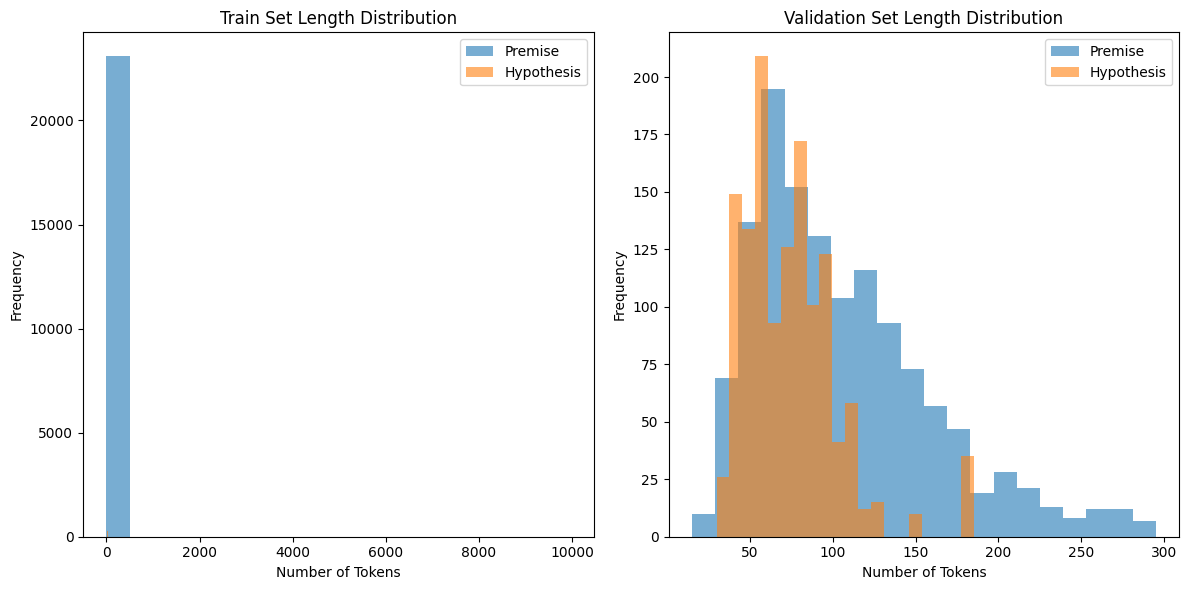

In [ ]:
train_prem_lengths = [len(premise) for premise in X_train['premise']]
train_hyp_lengths = [len(hypothesis) for hypothesis in X_train['hypothesis']]

val_prem_lengths = [len(premise) for premise in X_val['premise']]
val_hyp_lengths = [len(hypothesis) for hypothesis in X_val['hypothesis']]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Train set
axs[0].hist(train_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[0].hist(train_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[0].set_title("Train Set Length Distribution")
axs[0].set_xlabel("Number of Tokens")
axs[0].set_ylabel("Frequency")
axs[0].legend()

# Validation set
axs[1].hist(val_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[1].hist(val_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[1].set_title("Validation Set Length Distribution")
axs[1].set_xlabel("Number of Tokens")
axs[1].set_ylabel("Frequency")
axs[1].legend()

plt.tight_layout()
plt.show()

This indicates there are some outliers in the train set. Reviewing the ten largest premises in the training set reveals there are some abnormally large instances:

In [ ]:
largest_prem = sorted(range(len(train_prem_lengths)), key=lambda i: train_prem_lengths[i], reverse=True)[:10]
print([train_prem_lengths[i] for i in largest_prem])

[9966, 5829, 2249, 1154, 938, 705, 594, 550, 314, 111]


Removing these outliers from the training set, we get a nicer looking plot:

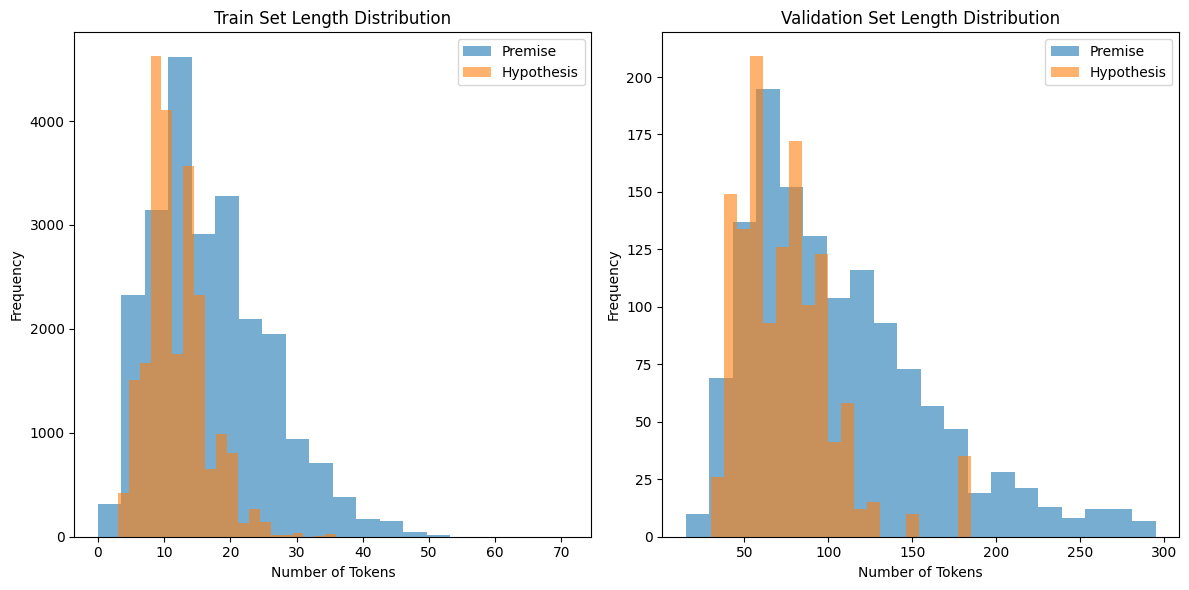

In [ ]:
X_train = X_train.drop(X_train.index[largest_prem])
y_train = y_train.drop(y_train.index[largest_prem])

train_prem_lengths = [len(premise) for premise in X_train['premise']]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Train set
axs[0].hist(train_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[0].hist(train_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[0].set_title("Train Set Length Distribution")
axs[0].set_xlabel("Number of Tokens")
axs[0].set_ylabel("Frequency")
axs[0].legend()

# Validation set
axs[1].hist(val_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[1].hist(val_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[1].set_title("Validation Set Length Distribution")
axs[1].set_xlabel("Number of Tokens")
axs[1].set_ylabel("Frequency")
axs[1].legend()

plt.tight_layout()
plt.show()

### 1.6. Dataset Formation
Now we create the training dataset. The tokenised premise and hypothesis sentences are encoded to be the index that corresponds to the word embedding in the embeddings table. Each sentence is then padded to be the same length as the longest respective premise or hypothesis.

In [ ]:
def encode_sentences(sentences):
    encoded_sentences = []
    for sentence in sentences:
        encoded_sentences.append([wordindexes[word] if word in wordindexes else wordindexes['[OOV]'] for word in sentence])
    return encoded_sentences

def pad_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_length:
            padded_seq = seq + [wordindexes['[PAD]']] * (max_length - len(seq))
        else:
            padded_seq = seq[:max_length]
        padded_sequences.append(padded_seq)
    return padded_sequences

max_prem = max(len(sentence) for sentence in X_train['premise'])
max_hyp = max(len(sentence) for sentence in X_train['hypothesis'])
encoded_prem_train = pad_sequences(encode_sentences(X_train['premise']), max_prem)
encoded_hyp_train = pad_sequences(encode_sentences(X_train['hypothesis']), max_hyp)

encoded_prem_val = pad_sequences(encode_sentences(X_val['premise']), max_prem)
encoded_hyp_val = pad_sequences(encode_sentences(X_val['hypothesis']), max_hyp)

The labels are now converted to 0 for neutral, and 1 for entails.

In [ ]:
y_train = y_train.map({'neutral': 0, 'entails': 1})
y_val = y_val.map({'neutral': 0, 'entails': 1})
y_test = y_test.map({'neutral': 0, 'entails': 1})

Now we can create the dataset and data loaders for the train and validation set. To reduce the impact of the class imbalance in the train set, the number of neutral samples is reduced to the number of entails samples.

In [ ]:
batch_size = 16

train_data = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_train), torch.tensor(encoded_hyp_train), torch.tensor(y_train.values))

neutral_indices = [i for i, label in enumerate(y_train.values) if label == 0]
entails_indices = [i for i, label in enumerate(y_train.values) if label == 1]

min_samplesize = min(len(neutral_indices), len(entails_indices))

# random sample from training set to make sure both are the same size
neutral_indices = random.sample(neutral_indices, min_samplesize)
entails_indices = random.sample(entails_indices, min_samplesize)

# combine the indices
train_indices = neutral_indices + entails_indices
random.shuffle(train_indices)

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)

val_data = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_val), torch.tensor(encoded_hyp_val), torch.tensor(y_val.values))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

#### 1.6.1 Usage for VSE

In [26]:
import numpy as np

class NLIPairDataset(torch.utils.data.Dataset):
    def __init__(self, premises_tok, hypos_tok, labels, wordindexes):
        self.premises_tok = premises_tok   # list of token lists
        self.hypos_tok = hypos_tok
        self.labels = labels         # list/array of ints 0/1
        self.wordindexes = wordindexes

    def __len__(self): return len(self.labels)

    def encode(self, toks):
        return [self.wordindexes.get(w, self.wordindexes['[OOV]']) for w in toks]

    def __getitem__(self, i):
        p_ids = torch.tensor(self.encode(self.premises_tok[i]), dtype=torch.long)
        h_ids = torch.tensor(self.encode(self.hypos_tok[i]),    dtype=torch.long)
        y = torch.tensor(int(self.labels[i]), dtype=torch.long)
        return {"premise_ids": p_ids, "hypo_ids": h_ids, "labels": y}

def collate_bilstm(batch, max_len=128, pad_id=0):

    def pad_with_lengths(seqs, pad_id=0):
        lens = torch.tensor([len(s) for s in seqs], dtype=torch.long)
        L = min(max(lens).item(), max_len)
        out = torch.full((len(seqs), L), pad_id, dtype=torch.long)
        for i, s in enumerate(seqs):
            s = s[:L]; out[i, :len(s)] = s
        return out, lens.clamp_max(L)

    p = [b["premise_ids"] for b in batch]
    h = [b["hypo_ids"]    for b in batch]
    y = torch.stack([b["labels"] for b in batch])

    p_pad, p_len = pad_with_lengths(p, pad_id=wordindexes['[PAD]'])
    h_pad, h_len = pad_with_lengths(h, pad_id=wordindexes['[PAD]'])

    return {
        "premise_ids": p_pad,
        "premise_lengths": p_len,
        "hypo_ids": h_pad,
        "hypo_lengths": h_len,
        "labels": y,
    }

# Build datasets from your existing tokenised lists
train_ds = NLIPairDataset(
    premises_tok=X_train['premise'].tolist(),   # token lists
    hypos_tok=X_train['hypothesis'].tolist(),
    labels=[LABEL_MAP[l] for l in y_train],     # ensure int labels
    wordindexes=wordindexes
)

val_ds = NLIPairDataset(
    premises_tok=X_val['premise'].tolist(),
    hypos_tok=X_val['hypothesis'].tolist(),
    labels=[LABEL_MAP[l] for l in y_val],
    wordindexes=wordindexes
)

test_ds = NLIPairDataset(
    premises_tok=X_test['premise'].tolist(),
    hypos_tok=X_test['hypothesis'].tolist(),
    labels=[LABEL_MAP[l] for l in y_test],
    wordindexes=wordindexes
)

# Keep class balancing indices, but feed them to DataLoader via sampler
neutral_indices = [i for i, label in enumerate(train_ds.labels) if label == 0]
entails_indices = [i for i, label in enumerate(train_ds.labels) if label == 1]

min_samplesize = min(len(neutral_indices), len(entails_indices))

# random sample from training set to make sure both are the same size
neutral_indices = random.sample(neutral_indices, min_samplesize)
entails_indices = random.sample(entails_indices, min_samplesize)

# combine the indices
train_indices = neutral_indices + entails_indices
random.shuffle(train_indices)

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)

prem_lens = np.array([len(ex["premise_tokens"]) for ex in train_data])
hypo_lens = np.array([len(ex["hypo_tokens"]) for ex in train_data])
all_lens  = np.concatenate([prem_lens, hypo_lens])

p = 99.5  # value between ~95-99 (.5% is a massive outlier)
suggested = int(np.percentile(all_lens, p))
MAX_LEN = min(suggested, 256)  # hard cap to keep things fast

trunc_frac = (all_lens > MAX_LEN).mean()
print(f"len stats → mean={all_lens.mean():.1f}, p95={np.percentile(all_lens,95):.0f}, p98={np.percentile(all_lens,98):.0f}, max={all_lens.max()}")
print(f"MAX_LEN set to {MAX_LEN} (truncates ~{trunc_frac*100:.1f}% tokens)")


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size,
    # sampler=train_sampler,             # your SubsetRandomSampler
    collate_fn=lambda b: collate_bilstm(b, max_len=MAX_LEN, pad_id=wordindexes['[PAD]'])
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    collate_fn=lambda b: collate_bilstm(b, max_len=MAX_LEN, pad_id=wordindexes['[PAD]'])
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=False,
    collate_fn=lambda b: collate_bilstm(b, max_len=MAX_LEN, pad_id=wordindexes['[PAD]'])
)
# Class weights for cross-entropy
# Collect train labels once from the dataset (faster & cleaner than looping the loader)
import numpy as np, torch
labels_train = [train_ds[i]["labels"] for i in range(len(train_ds))]  # assume __getitem__ returns dict with "labels"
counts = np.bincount(labels_train, minlength=2)
freq = counts / counts.sum()
w = 1.0 / (freq + 1e-8)                           # inverse-frequency
w = w / w.sum() * 2.0                             # mild normalisation (sum≈2 keeps CE scale reasonable)
model.class_weights = torch.tensor(w, dtype=torch.float32, device=CFG.device)
print("Class weights (0,1):", model.class_weights.tolist(), " | counts:", counts.tolist())

len stats → mean=14.9, p95=29, p98=35, max=9944
MAX_LEN set to 42 (truncates ~0.5% tokens)
Class weights (0,1): [0.7337144613265991, 1.2662855386734009]  | counts: [14618, 8470]


### 1.7 Test Dataset
Finally, we create the test dataset in a similar way the training and validation sets are created.

In [ ]:
max_prem = max(len(sentence) for sentence in X_test['premise'])
max_hyp = max(len(sentence) for sentence in X_test['hypothesis'])
encoded_prem_test = pad_sequences(encode_sentences(X_test['premise']), max_prem)
encoded_hyp_test = pad_sequences(encode_sentences(X_test['hypothesis']), max_hyp)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_test), torch.tensor(encoded_hyp_test), torch.tensor(y_test.values))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Dataloader sample usage
# for i, batch in enumerate(train_loader):
    # i = batch number
    # premises   = batch[0]
    # hypotheses = batch[1]
    # labels     = batch[2]

#### 1.7.1 For VSE
(padding handled in collate_bilstm)

In [14]:
# get one batch
batch = next(iter(train_loader))

# expect these keys
print("keys:", list(batch.keys()))
assert "premise_ids" in batch and "hypo_ids" in batch
assert "premise_lengths" in batch and "hypo_lengths" in batch
assert "labels" in batch

# shapes
print("premise_ids shape:", batch["premise_ids"].shape)
print("hypo_ids shape:   ", batch["hypo_ids"].shape)
print("premise_len shape:", batch["premise_lengths"].shape)
print("hypo_len shape:   ", batch["hypo_lengths"].shape)
print("labels shape:     ", batch["labels"].shape)

# peek at first example
i = 0
p_len = int(batch["premise_lengths"][i])
h_len = int(batch["hypo_lengths"][i])
print(f"\nexample {i}: p_len={p_len}, h_len={h_len}, label={int(batch['labels'][i])}")

# show first few ids (should be non-zero up to length, then zeros)
print("premise_ids[:15]:", batch["premise_ids"][i, :15].tolist())
print("hypo_ids[:15]:   ", batch["hypo_ids"][i, :15].tolist())

# quick sanity: pads should be 0 and only after length
pad_id = 0
prem_ids = batch["premise_ids"][i].tolist()
hypo_ids  = batch["hypo_ids"][i].tolist()

assert all(x != pad_id for x in prem_ids[:p_len]), "pad inside premise actual tokens?"
assert all(x == pad_id for x in prem_ids[p_len:]), "no padding after premise length?"

assert all(x != pad_id for x in hypo_ids[:h_len]), "pad inside hypo actual tokens?"
assert all(x == pad_id for x in hypo_ids[h_len:]), "no padding after hypo length?"


keys: ['premise_ids', 'premise_lengths', 'hypo_ids', 'hypo_lengths', 'labels']
premise_ids shape: torch.Size([32, 42])
hypo_ids shape:    torch.Size([32, 42])
premise_len shape: torch.Size([32])
hypo_len shape:    torch.Size([32])
labels shape:      torch.Size([32])

example 0: p_len=42, h_len=42, label=0
premise_ids[:15]: [38, 11, 16, 4, 6, 2, 10, 6, 4, 5, 4, 3, 7, 2, 6]
hypo_ids[:15]:    [37, 5, 10, 4, 12, 2, 10, 6, 4, 5, 4, 3, 7, 2, 6]


##### Saanity Check

In [15]:
# dataloader check
batch = next(iter(train_loader))
print("keys:", list(batch.keys()))
print({k:v.shape for k,v in batch.items() if k!='labels'}, "labels:", batch["labels"].shape)

i = 0
p_len = int(batch["premise_lengths"][i]); h_len = int(batch["hypo_lengths"][i])
pad_id = 0
prem_ids = batch["premise_ids"][i].tolist()
hypo_ids = batch["hypo_ids"][i].tolist()

assert all(x != pad_id for x in prem_ids[:p_len]) and all(x == pad_id for x in prem_ids[p_len:])
assert all(x != pad_id for x in hypo_ids[:h_len]) and all(x == pad_id for x in hypo_ids[h_len:])
print("batch looks sane")

keys: ['premise_ids', 'premise_lengths', 'hypo_ids', 'hypo_lengths', 'labels']
{'premise_ids': torch.Size([32, 42]), 'premise_lengths': torch.Size([32]), 'hypo_ids': torch.Size([32, 42]), 'hypo_lengths': torch.Size([32])} labels: torch.Size([32])
batch looks sane


# 2. Variational Siamese Encoder Model

This section implements the Variational Siamese Encoder for NLI. Each sentence is encoded by a BiLSTM into a latent distribution (μ, logσ²). A latent vector z is sampled using the reparameterization trick. The premise and hypothesis encodings are then combined and passed through an MLP classifier. Training uses cross-entropy plus KL divergence to regularize the latent space.


## 2.1 Config
configuring hyperparameters and the device

In [27]:
from dataclasses import dataclass, asdict

@dataclass
class Config:
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    embedding_dim: int = 100
    lstm_hidden: int = 300 #risen from 256
    lstm_layers: int = 1
    bidir: bool = True
    dropout: float = 0.1
    latent_dim: int = 128 #risen from 64
    beta: float = 0.004 #starting low (initially rising too high)
    mlp_hidden: int = 256 #risen from 128
    lr: float = 2e-4
    weight_decay: float = 0.01
    epochs: int = 10

CFG = Config()

## 2.2 Encoder (BiLSTM) + pooling

In [28]:
import torch.nn as nn

# Mean-pooling layer that ignores padding tokens via a mask
class MaskedMeanPool(nn.Module):
    def forward(self, x, mask):
        # x: [B,L,H], mask: [B,L] (1=real, 0=pad)
        mask = mask.float().unsqueeze(-1)
        x = x * mask #zero-out pads
        denom = mask.sum(dim=1).clamp_min(1e-6) #avoid zero-division
        return x.sum(dim=1) / denom #mean of reaal tokens

# BiLSTM sentence encoder with masked mean pooling over token states
class BiLSTMEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=200, hidden=256, layers=1, bidir=True, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)  # PAD=0
        self.lstm = nn.LSTM(
            emb_dim, hidden, num_layers=layers, batch_first=True,
            bidirectional=bidir, dropout=dropout if layers > 1 else 0.0 #dropout only if layers > 1
        )
        self.hidden = hidden * (2 if bidir else 1) #biLSTM doubles the hidden size
        self.pool = MaskedMeanPool()

    def forward(self, ids, lengths):
        emb = self.embed(ids)  # [B,L,E]
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        seq, _ = self.lstm(packed)
        seq, _ = nn.utils.rnn.pad_packed_sequence(seq, batch_first=True, total_length=ids.size(1))  # [B,L,H]
        mask = (ids != 0).long()
        s = self.pool(seq, mask)  # [B,H]
        return s


## 2.3 VSE Model
variational heads + comparator + classifier

In [29]:
import torch.nn.functional as F
import torch

# Variational Siamese NLI model: encodes both sentences, reparameterizes z, then classifies their relation
class VariationalSiameseEncoder(nn.Module):
    def __init__(self, encoder, H, D, mlp_hidden=128, dropout=0.1):
        super().__init__()
        self.encoder = encoder           # shared sentence encoder ϕ
        self.mu = nn.Linear(H, D)       # mean head over sentence rep s
        self.logvar = nn.Linear(H, D)   # log-variance head over s
        self.classifier = nn.Sequential(
            nn.Linear(2*D + 2*H, CFG.mlp_hidden),
            nn.ReLU(),
            nn.Dropout(CFG.dropout),
            nn.Linear(CFG.mlp_hidden, 2)

            # nn.Linear(2*D, mlp_hidden),
            # nn.ReLU(),
            # nn.Dropout(dropout),
            # nn.Linear(mlp_hidden, 2)
        )

    def _encode(self, s):
        return self.mu(s), self.logvar(s)

    def _reparam(self, mu, logv, use_mu_inference=False):
        if use_mu_inference:    # deterministic path at eval
            return mu
        std = (0.5 * logv).exp()
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, batch, beta=0.01, use_mu_inference=False):
        # encode premise and hypothesis -> sentence reps s1, s2
        s1 = self.encoder(batch["premise_ids"], batch["premise_lengths"])
        s2 = self.encoder(batch["hypo_ids"], batch["hypo_lengths"])

        # VAE heads + reparameterization for each side
        mu1, logv1 = self._encode(s1)
        mu2, logv2 = self._encode(s2)
        z1 = self._reparam(mu1, logv1, use_mu_inference)
        z2 = self._reparam(mu2, logv2, use_mu_inference)


        # pair features: |z1−z2|, z1·z2 plus raw s1,s2 (helps classifier)
        feat = torch.cat([torch.abs(z1 - z2), z1 * z2, s1, s2], dim=-1)
        logits = self.classifier(feat)

        if "labels" not in batch:
            return {"logits": logits}

        labels = batch["labels"]
        ce = F.cross_entropy(logits, labels, weight=getattr(self, "class_weights", None)) #OLD: ce  = F.cross_entropy(logits, labels)  # task loss
        # KL for each side (diag Gaussian vs. N(0, I))
        kl1 = 0.5 * torch.sum(torch.exp(logv1) + mu1**2 - 1. - logv1, dim=1).mean()
        kl2 = 0.5 * torch.sum(torch.exp(logv2) + mu2**2 - 1. - logv2, dim=1).mean()
        kl  = kl1 + kl2
        loss = ce + beta * kl
        return {"logits": logits, "loss_total": loss, "loss_task": ce, "loss_kl": kl}


## 2.4 Build the Model

In [30]:
# Build VSE-BiLSTM model and load pre-trained GloVe embeddings
vocab_size = len(wordindexes) if isinstance(wordindexes, dict) else len(vocab)  # adapt to vocab container
H = CFG.lstm_hidden * (2 if CFG.bidir else 1)         # BiLSTM doubles hidden size if bidirectional

encoder = BiLSTMEncoder(
    vocab_size=vocab_size,
    emb_dim=CFG.embedding_dim,     #must match emb_table dim (100 for glove-twitter-100)
    hidden=CFG.lstm_hidden,
    layers=CFG.lstm_layers,
    bidir=CFG.bidir,
    dropout=CFG.dropout
)

model = VariationalSiameseEncoder(
    encoder=encoder,
    H=H,
    D=CFG.latent_dim,     # latent z dim for each side
    mlp_hidden=CFG.mlp_hidden,
    dropout=CFG.dropout
).to(CFG.device)

#load pre-trained GloVe into the embedding layer (ensure shapes match)
assert model.encoder.embed.weight.data.shape == torch.Size(emb_table.shape), \
    f"Embedding shape mismatch: layer {tuple(model.encoder.embed.weight.shape)} vs table {emb_table.shape}"

with torch.no_grad():
    model.encoder.embed.weight.data.copy_(torch.tensor(emb_table, dtype=torch.float32))  #init from GloVe


sum_params = sum(p.numel() for p in model.parameters())/1e6
print(f"Model ready. Params: {sum_params:.2f}M  |  H={H}, D={CFG.latent_dim}")


Model ready. Params: 1.50M  |  H=600, D=128


##### Sanity Check

In [31]:
# tiny-batch overfit (run once for debugging)
tiny = next(iter(train_loader))
tiny = {k: v.to(CFG.device) for k,v in tiny.items()}

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.0)

model.train() # Set model to training mode before the loop
for _ in range(200):
    out = model(tiny, beta=0.0, use_mu_inference=False)  # no KL
    opt.zero_grad()
    out["loss_task"].backward()
    opt.step()

model.eval() # Set model back to evaluation mode after the loop
with torch.no_grad():
    preds = model(tiny, beta=0.0, use_mu_inference=True)["logits"].argmax(-1)
    print("tiny overfit acc:", (preds == tiny["labels"]).float().mean().item())

tiny overfit acc: 1.0


## 2.5 Train/Val Loops
\+ best checkpoint

In [32]:
import time

# Training + evaluation loops with β warm-up, grad clipping, and best-checkpoint saving

def evaluate(model, loader, use_mu_inference=True):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(CFG.device) for k, v in batch.items()}
            out = model(batch, beta=CFG.beta, use_mu_inference=use_mu_inference)  # deterministic path at eval
            preds = out["logits"].argmax(-1)
            labels = batch["labels"]
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / max(total, 1)

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay) # WD on by default

best_val = -1.0
best_path = "best_vse_bilstm.pt"

for epoch in range(1, CFG.epochs+1):
    model.train()
    t0 = time.time()
    seen = 0
    loss_sum = task_sum = kl_sum = 0.0

    for batch in train_loader:
        batch = {k: v.to(CFG.device) for k, v in batch.items()}
        warmup_epochs = max(1, int(0.3 * CFG.epochs)) # 30% of training
        beta_t = CFG.beta * min(1.0, epoch / warmup_epochs)  # linear warm-up over number of epochs
        out = model(batch, beta=beta_t, use_mu_inference=False)  # stochastic z during training   ---   #previous: out = model(batch, beta=CFG.beta, use_mu_inference=False)
        loss = out["loss_total"]
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip to stabilise LSTM
        optimizer.step()

        bs = batch["labels"].size(0)
        seen += bs
        loss_sum += out["loss_total"].item() * bs
        task_sum += out["loss_task"].item() * bs
        kl_sum += out["loss_kl"].item() * bs

    train_loss = loss_sum / max(1, seen)
    train_task = task_sum / max(1, seen)
    train_kl = kl_sum / max(1, seen)
    val_acc = evaluate(model, val_loader, use_mu_inference=True)
    print(f"Epoch {epoch:02d} | {time.time()-t0:.1f}s | loss={train_loss:.4f} (task={train_task:.4f}, kl={train_kl:.4f}) | val_acc={val_acc:.4f}")

    # quick diagnostic: average logits on val to spot class bias
    with torch.no_grad():
        s = torch.zeros(2, device=CFG.device); n=0
        for b in val_loader:
            b = {k:v.to(CFG.device) for k,v in b.items()}
            lg = model(b, beta=0.0, use_mu_inference=True)["logits"]
            s += lg.mean(0); n += 1
        print("avg val logits:", (s/n).tolist())

    if val_acc > best_val:     # save best-by-val-acc checkpoint
        best_val = val_acc
        torch.save({"state": model.state_dict(), "cfg": asdict(CFG)}, best_path)
        print("  saved best ->", best_path)

print("Best val acc:", best_val)


Epoch 01 | 15.1s | loss=0.7120 (task=0.7093, kl=1.9788) | val_acc=0.5383
avg val logits: [0.1180984303355217, -0.28642499446868896]
  saved best -> best_vse_bilstm.pt
Epoch 02 | 13.9s | loss=0.6577 (task=0.6572, kl=0.2097) | val_acc=0.5414
avg val logits: [0.11403302103281021, -0.300849586725235]
  saved best -> best_vse_bilstm.pt
Epoch 03 | 14.0s | loss=0.6542 (task=0.6537, kl=0.1397) | val_acc=0.5261
avg val logits: [0.17024260759353638, -0.3241632282733917]
Epoch 04 | 13.6s | loss=0.6528 (task=0.6519, kl=0.2264) | val_acc=0.5360
avg val logits: [0.3094739019870758, -0.22736160457134247]
Epoch 05 | 13.5s | loss=0.6551 (task=0.6547, kl=0.1133) | val_acc=0.5567
avg val logits: [0.2625819146633148, -0.2023775279521942]
  saved best -> best_vse_bilstm.pt
Epoch 06 | 13.5s | loss=0.6497 (task=0.6493, kl=0.1077) | val_acc=0.5897
avg val logits: [0.10128901153802872, -0.12885130941867828]
  saved best -> best_vse_bilstm.pt
Epoch 07 | 13.4s | loss=0.6471 (task=0.6466, kl=0.1136) | val_acc=0.5

## 2.6 Final Test Evaluation
and confusion matrix

Loaded best_vse_bilstm.pt
Test accuracy: 0.5964
Confusion matrix (rows=true, cols=pred):
 [[893 391]
 [467 375]]
              precision    recall  f1-score   support

 neutral (0)      0.657     0.695     0.675      1284
 entails (1)      0.490     0.445     0.466       842

    accuracy                          0.596      2126
   macro avg      0.573     0.570     0.571      2126
weighted avg      0.590     0.596     0.593      2126



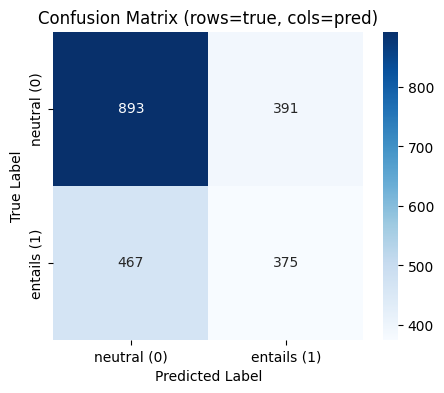

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

# load best
if os.path.exists(best_path):
    ckpt = torch.load(best_path, map_location=CFG.device)
    model.load_state_dict(ckpt["state"])
    print("Loaded", best_path)

# evaluate with deterministic inference (use μ)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(CFG.device) for k, v in batch.items()}
        out = model(batch, beta=CFG.beta, use_mu_inference=True)
        preds = out["logits"].argmax(-1).cpu().numpy()
        labs  = batch["labels"].cpu().numpy()
        all_preds.append(preds); all_labels.append(labs)

preds = np.concatenate(all_preds) if all_preds else np.array([])
labs  = np.concatenate(all_labels) if all_labels else np.array([])
acc = (preds == labs).mean() if preds.size else 0.0

cm = np.zeros((2,2), dtype=int)
for t,p in zip(labs, preds): cm[t,p] += 1

print(f"Test accuracy: {acc:.4f}")
print("Confusion matrix (rows=true, cols=pred):\n", cm)
report = classification_report(labs, preds, target_names=["neutral (0)", "entails (1)"], digits=3)
print(report)

labels = ["neutral (0)", "entails (1)"]
cm = confusion_matrix(labs, preds, labels=[0,1])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (rows=true, cols=pred)")
plt.show()